In [61]:
import os
import sys
import datacube
import numpy as np
#import geopandas as gpd
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from odc.ui import with_ui_cbk
#from datacube.utils import masking
#import matplotlib.dates as mdates
import time

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#from scipy.stats import pearsonr

sys.path.append('../dea-notebooks/Scripts/')
import dea_datahandling
from datacube.utils import geometry as geom
sys.path.append('../dea-notebooks/Scripts/')
sys.path.append('../fc_juan')

import dea_datahandling
from datacube.model import Measurement
from datacube.utils import unsqueeze_dataset
from odc.algo import to_f32, xr_geomedian, int_geomedian


#sys.path.append('../')
os.chdir('../fc')
from fc.fractional_cover import fractional_cover 

In [62]:
def load_s2_reflectance(date_init, date_end, ul_coord, lr_coord, crs, dask_chunks):
    lat_north = ul_coord[0] 
    lat_south = lr_coord[0]
    lon_west  = ul_coord[1]
    lon_east  = lr_coord[1]

    dc = datacube.Datacube()
    
    query = {
        "time": (date_init, date_end),
        "x": (lon_west,lon_east),
        "y": (lat_north, lat_south),
        "products": ["s2a_ard_granule", "s2b_ard_granule"], 
        "measurements":[#"nbart_blue", 
                        "nbart_green", 
                        "nbart_red", 
                        #"nbart_red_edge_1", 
                        #"nbart_red_edge_2", 
                        #"nbart_red_edge_3", 
                        "nbart_nir_1", 
                        #"nbart_nir_2", 
                        "nbart_swir_2", 
                        "nbart_swir_3"],
        "resolution": (-30, 30),
        "crs": crs,        
        "output_crs": "EPSG:3577",
        "dask_chunks": dask_chunks,
        "min_gooddata": 0.0, 
        "group_by": "solar_day",
        'resampling': 'bilinear'
    }
    print(query)
    ds = dea_datahandling.load_ard(dc=dc,  **query) # progress_cbk=with_ui_cbk()
    return ds

def load_L578_reflectance(date_init, date_end, ul_coord, lr_coord, crs, dask_chunks, product):
    lat_north = ul_coord[0] 
    lat_south = lr_coord[0]
    lon_west  = ul_coord[1]
    lon_east  = lr_coord[1]

    dc = datacube.Datacube()
 
    if product == 'L8':
        products = ['ga_ls8c_ard_3']
    if product == 'L57':
        products = ['ga_ls5t_ard_3','ga_ls7e_ard_3']
    
    query = {
        "time": (date_init, date_end),
        "x": (lon_west,lon_east),
        "y": (lat_north, lat_south),
        "products": products,
        
        "measurements": [#"nbart_blue", 
                         "nbart_green", 
                         "nbart_red", 
                         "nbart_nir", 
                         "nbart_swir_1", 
                         "nbart_swir_2"],
        "resolution": (-30, 30),
        "crs": crs,
        "output_crs": "EPSG:3577",
        
        "dask_chunks": dask_chunks,
    #    'min_gooddata':0.75, 
         "min_gooddata": 0.0, 
         "group_by": "solar_day"
    }
    #print(query)

    start = time.process_time()
    ds = dea_datahandling.load_ard(dc=dc, **query) #,progress_cbk=with_ui_cbk(), 
    print(time.process_time() - start, ' seconds for load_L578_reflectance')

    return ds


def L8toL57(ds):
    """
    Apply regression coefficients in the form: ETM = c0 + OLI*c1
    As per table 2 in http://www.mdpi.com/2072-4292/6/9/7952/htm
    :param numpyarray: array of measurements to apply coefficients to
    :param band: name of the coefficient pair to apply
    :return: updated array
    """    
    
    # adapted from https://github.com/GeoscienceAustralia/fc/blob/master/fc/fractional_cover.py#L177 
    
    ds['nbart_green'] = ds['nbart_green'] * 0.99779 + 0.00289 * 10000
    ds['nbart_red'] = ds['nbart_red'] * 1.00446 + 0.00274 * 10000
    ds['nbart_nir'] = ds['nbart_nir'] * 0.98906 + 0.00004 * 10000
    ds['nbart_swir_1'] = ds['nbart_swir_1'] * 0.99467 + 0.00256 * 10000
    ds['nbart_swir_2'] = ds['nbart_swir_2'] * 1.02551 - 0.00327 * 10000
    
    #make sure thare aren't any negative values (it happens sometimes)
    #ds = np.maximum(0, ds)
    ds = ds.where(ds >= 0)
    
    return ds

def S2toL57(ds):
    """
    Apply regression coefficients in the form: ETM = c0 + S2*c1
    As per table 4 in www.doi.org/10.3390/rs9070659 
    Table 4. Coefficients for Equation (1), to adjust Sentinel-2A reflectance to the corresponding Landsat reflectance. Fitted from the training data described in Table 3.
    Coefficient	Blue	Green	Red	NIR	SWIR1	SWIR2
    Landsat-7	 c0 	−0.0022	0.0031	0.0064	0.012	0.0079	−0.0042
    c1 	0.9551	1.0582	0.9871	1.0187	0.9528	0.9688
    Landsat-8	 c0 	−0.0012	0.0013	0.0027	0.0147	0.0025	−0.0011
    c1 	0.963	1.0473	0.9895	1.0129	0.9626	0.9392    

    """    
        
    ds['nbart_green'] = ds['nbart_green'] * 1.0582 + 0.0031 * 10000
    ds['nbart_red'] = ds['nbart_red'] * 0.9871 + 0.0064 * 10000
    ds['nbart_nir_1'] = ds['nbart_nir_1'] * 1.0187 + 0.012 * 10000
    ds['nbart_swir_2'] = ds['nbart_swir_2'] * 0.9528 + 0.0079 * 10000
    ds['nbart_swir_3'] = ds['nbart_swir_3'] * 0.9688 - 0.0042 * 10000
    
    #make sure thare aren't any negative values (it happens sometimes)
    #ds = np.maximum(0, ds)
    ds = ds.where(ds >= 0)

    return ds

def rename_bands_L578(ds):
    ds = ds.rename({ #'nbart_blue':   'blue',
                     'nbart_green':  'green',
                     'nbart_red':    'red',
                     'nbart_nir':    'nir',
                     'nbart_swir_1': 'swir1',
                     'nbart_swir_2': 'swir2'})
    return ds

def rename_bands_S2(ds):
    ds = ds.rename({ #'nbart_blue':   'blue',
                     'nbart_green':  'green',
                     'nbart_red':    'red',
                     'nbart_nir_1':    'nir',
                     'nbart_swir_2': 'swir1',
                     'nbart_swir_3': 'swir2'})
    return ds


In [63]:
def load_L578(date_init, date_end, ul_coord, lr_coord, dst_crs, dask_chunks):

    L57=[]
    L8=[]
    L578=[]
    L578_r=[]

    try:
        L57 = load_L578_reflectance(date_init, date_end, ul_coord, lr_coord, dst_crs, dask_chunks, 'L57') 
        #L57['sensor'] = 'L57'
        L578.append(L57)
    except:
        print('no L57 data')

    try:
        L8 = load_L578_reflectance(date_init, date_end, ul_coord, lr_coord, dst_crs, dask_chunks, 'L8') 
        # apply Neil Flood's linear correction
        L8 = L8toL57(L8)
        #L8['sensor'] = 'L8'
        L578.append(L8)
    except:
        print('no L8 data')

    L578_r = xr.concat(L578, dim='time').sortby('time')
    L578_r = L578_r.chunk(chunks=dask_chunks)
    
    return L578_r

def load_L578_S2_reflectance(date_init, date_end, ul_coord, lr_coord, dst_crs, dask_chunks):
    # load Lansat 5,7,8
    L578 = load_L578(date_init_UTC, date_end_UTC, ul_coord, lr_coord, dst_crs, dask_chunks)
    # convert the timestamps back to AEST
    L578.assign(time= pd.to_datetime(L578.time.values).tz_localize('UTC').tz_convert('Australia/Sydney').tz_localize(None))

    # load S2 
    S2 = load_s2_reflectance(date_init_UTC, date_end_UTC, ul_coord, lr_coord, dst_crs, dask_chunks) 
    # convert the timestamps back to AEST
    S2.assign(time= pd.to_datetime(S2.time.values).tz_localize('UTC').tz_convert('Australia/Sydney').tz_localize(None))
    # Apply Neil flood's band conversions
    S2 = S2toL57(S2)

    # merge (concat) Landsat and S2 reflectances. Needs to rename the bands first
    L_S2 = xr.concat([rename_bands_L578(L578[['nbart_green','nbart_red','nbart_nir','nbart_swir_1','nbart_swir_2']]), 
                      rename_bands_S2((S2[['nbart_green','nbart_red','nbart_nir_1','nbart_swir_2','nbart_swir_3']]))], dim='time').sortby('time')
    return L_S2

In [4]:
# Initiliaze the Gateway client
from dask.distributed import Client
from dask_gateway import Gateway

gateway = Gateway()
gateway.cluster_options()

clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster. Please wait for this to finish.')
    cluster = gateway.new_cluster()
else:
    print(f'An existing cluster was found. Connected to cluster \033[1m{clusters[0].name}\033[0m')
    cluster=gateway.connect(clusters[0].name)
display(cluster)


min_number_of_workers = 2
max_number_of_workers = 4

# Static scaling
cluster.scale(min_number_of_workers)

# Adaptive scaling
cluster.adapt(minimum=min_number_of_workers, maximum=max_number_of_workers)


client = cluster.get_client()
client.wait_for_workers(n_workers=min_number_of_workers)
# client

client, cluster

Creating new cluster. Please wait for this to finish.


(<Client: 'tls://10.0.61.61:8786' processes=0 threads=0, memory=0 B>,
 GatewayCluster<easihub.6e739900de234b6aa6f824bace0e45c1, status=running>)

In [64]:

#date_init = '2020-12-24'
#date_end = '2020-12-25'
date_init = '2015-01-01'
date_end = '2021-12-31'

# convert the dates to UTC to make sure we get the data we want for AEST 
date_init_UTC = pd.to_datetime(date_init).tz_localize('Australia/Sydney').tz_convert('UTC').tz_localize(None).strftime('%Y-%m-%d %H:%M:%S')
date_end_UTC = (pd.to_datetime(date_end) + pd.Timedelta(1, unit='D')).tz_localize('Australia/Sydney').tz_convert('UTC').tz_localize(None).strftime('%Y-%m-%d %H:%M:%S')
    
lat, lon = (-29.39938, 150.13736)
buffer=1000
dst_crs = 'epsg:3577'
x, y = geom.point(lon, lat, geom.CRS('epsg:4326')).to_crs(geom.CRS(dst_crs)).coords[0]
ul_coord = [y+buffer, x-buffer]
lr_coord = [y-buffer, x+buffer]
dask_chunks={"time": -1, "x": -1, "y": -1}


In [65]:
L_S2_reflectance = load_L578_S2_reflectance(date_init_UTC, date_end_UTC, ul_coord, lr_coord, dst_crs, dask_chunks)

L_S2_reflectance

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
Applying pixel quality/cloud mask
Returning 189 time steps as a dask array
0.636706332000017  seconds for load_L578_reflectance
Finding datasets
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 141 time steps as a dask array
0.4680755389999831  seconds for load_L578_reflectance
{'time': ('2014-12-31 13:00:00', '2021-12-31 13:00:00'), 'x': (1733159.2415405952, 1735159.2415405952), 'y': (-3318280.811331162, -3320280.811331162), 'products': ['s2a_ard_granule', 's2b_ard_granule'], 'measurements': ['nbart_green', 'nbart_red', 'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3'], 'resolution': (-30, 30), 'crs': 'epsg:3577', 'output_crs': 'EPSG:3577', 'dask_chunks': {'time': -1, 'x': -1, 'y': -1}, 'min_gooddata': 0.0, 'group_by': 'solar_day', 'resampling': 'bilinear'}
Finding datasets
    s2a_ard_granule


/env/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 134 times more chunks
  return self.array[key]
/env/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 134 times more chunks
  return self.array[key]
/env/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 134 times more chunks
  return self.array[key]
/env/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 134 times more chunks
  return self.array[key]
/env/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 134 times more chunks
  return self.array[key]


    s2b_ard_granule
Applying pixel quality/cloud mask
Returning 640 time steps as a dask array


/env/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 231 times more chunks
  return self.array[key]
/env/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 231 times more chunks
  return self.array[key]
/env/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 231 times more chunks
  return self.array[key]
/env/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 231 times more chunks
  return self.array[key]
/env/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 231 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:      (time: 970, x: 68, y: 67)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-09T23:54:55.940638 ... 2021-08...
  * y            (y) float64 -3.318e+06 -3.318e+06 ... -3.32e+06 -3.32e+06
  * x            (x) float64 1.733e+06 1.733e+06 ... 1.735e+06 1.735e+06
    spatial_ref  int32 3577
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(48, 67, 68), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(48, 67, 68), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(48, 67, 68), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(48, 67, 68), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(48, 67, 68), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [66]:
# do I need to rechunk? Depends on the dims
# for a small area, long time series, do something like {"time": 10, "x": -1, "y": -1}
# for a large area, one month, {"time": 1, "x": 300, "y": 300}
# for a large area, long time series...  well, that's what I need help wit, woring with grid workflow
dask_chunks = {"time": 50, "x": -1, "y": -1}
L_S2_reflectance = L_S2_reflectance.chunk(chunks=dask_chunks)
L_S2_reflectance = L_S2_reflectance.compute()
L_S2_reflectance

<xarray.Dataset>
Dimensions:      (time: 970, x: 68, y: 67)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-09T23:54:55.940638 ... 2021-08...
  * y            (y) float64 -3.318e+06 -3.318e+06 ... -3.32e+06 -3.32e+06
  * x            (x) float64 1.733e+06 1.733e+06 ... 1.735e+06 1.735e+06
    spatial_ref  int32 3577
Data variables:
    green        (time, y, x) float32 nan nan nan ... 635.2 638.4 645.8
    red          (time, y, x) float32 nan nan nan ... 309.8 309.8 305.8
    nir          (time, y, x) float32 nan nan nan ... 5.428e+03 5.569e+03
    swir1        (time, y, x) float32 nan nan nan ... 1.875e+03 1.876e+03
    swir2        (time, y, x) float32 nan nan nan ... 783.4 768.9 765.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [67]:
# Calculate geomedian (this can be slow on large arrays, xr_geomedian is slow)
L_S2_gm = L_S2_reflectance.resample(time='1MS').map(xr_geomedian)
# get rid of zeros (xr_geomedian returns zeros, they should be NaNs!!)
L_S2_gm = L_S2_gm.where(L_S2_gm > 0)

# calculate number of valid obs
L_S2_gm_n = L_S2_reflectance.resample(time='1MS').count(dim='time')


/env/lib/python3.8/site-packages/odc/algo/_geomedian.py:106: RuntimeWarning: Mean of empty slice
  data = nangeomedian_pcm(xx_data, **kw)


### show me how they look

In [68]:
L_S2_gm

<xarray.Dataset>
Dimensions:  (time: 80, x: 68, y: 67)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2021-08-01
  * y        (y) float64 -3.318e+06 -3.318e+06 ... -3.32e+06 -3.32e+06
  * x        (x) float64 1.733e+06 1.733e+06 1.733e+06 ... 1.735e+06 1.735e+06
Data variables:
    green    (time, y, x) float32 1.297e+03 1.312e+03 1.303e+03 ... nan nan nan
    red      (time, y, x) float32 1.61e+03 1.628e+03 1.644e+03 ... nan nan nan
    nir      (time, y, x) float32 2.336e+03 2.355e+03 2.378e+03 ... nan nan nan
    swir1    (time, y, x) float32 3.199e+03 3.316e+03 3.269e+03 ... nan nan nan
    swir2    (time, y, x) float32 2.667e+03 2.828e+03 2.775e+03 ... nan nan nan

## this loads the Landsat FC from DEA  (commented, I don't need it now)

In [69]:
"""
dc = datacube.Datacube(app="L578_FC")

L578_fc = dc.load(product="ga_ls_fc_3", group_by="solar_day", like=L578_r, dask_chunks=dask_chunks)
wofl = dc.load(product="ga_ls_wo_3", group_by="solar_day", like=L578_fc.geobox, dask_chunks=dask_chunks) #, progress_cbk=with_ui_cbk())
clear = {"cloud_shadow": False, "cloud": False} #, "dry":True}
cloudfree = masking.make_mask(wofl, **clear)
L578_fc = L578_fc.where((cloudfree.water == True) & (L578_fc < 255))
 
L578_fc['totcov'] = L578_fc['pv']+L578_fc['npv']

L578_fc = L578_fc.compute()
L578_fc
"""

'\ndc = datacube.Datacube(app="L578_FC")\n\nL578_fc = dc.load(product="ga_ls_fc_3", group_by="solar_day", like=L578_r, dask_chunks=dask_chunks)\nwofl = dc.load(product="ga_ls_wo_3", group_by="solar_day", like=L578_fc.geobox, dask_chunks=dask_chunks) #, progress_cbk=with_ui_cbk())\nclear = {"cloud_shadow": False, "cloud": False} #, "dry":True}\ncloudfree = masking.make_mask(wofl, **clear)\nL578_fc = L578_fc.where((cloudfree.water == True) & (L578_fc < 255))\n \nL578_fc[\'totcov\'] = L578_fc[\'pv\']+L578_fc[\'npv\']\n\nL578_fc = L578_fc.compute()\nL578_fc\n'

## run FC for Landsat
this can also be VERY!! slow. 

In [70]:
my_measurements = []
my_measurements.append(Measurement(name='pv', dtype='int8', nodata=-1, units='percent'))
my_measurements.append(Measurement(name='npv', dtype='int8', nodata=-1, units='percent'))
my_measurements.append(Measurement(name='bs', dtype='int8', nodata=-1, units='percent'))
my_measurements

ds = []
for time in L_S2_gm.time.values: 
    
    input_tile  = L_S2_gm.sel(time=time) 

    # if this is L8 then correct reflectances so they look like L5 or L7
    #if product == 'L8':
    #    input_tile = L8toL57(input_tile)

    # rename the bands (fractional_cover wants them called 'green','red','nir','swir1','swir2')
    #input_tile = rename_bands_L578(input_tile)

    # run the unmixing
    fc_unmix_ = fractional_cover(input_tile, my_measurements)

    fc_unmix_['time'] = time
    # now reassemble the xarray 
    #fc_unmix = unsqueeze_dataset(fc_unmix_, 'time', L578_reflectance.time.values[0])

    # convert the no data (-1) into Nans
    fc_unmix_ = fc_unmix_.where(fc_unmix_ != -1)

    ds.append(fc_unmix_)
# show me the results
fc_unmix = xr.concat(ds, dim='time')
fc_unmix['tot'] = fc_unmix['pv']+fc_unmix['npv']
fc_unmix

<xarray.Dataset>
Dimensions:      (time: 80, x: 68, y: 67)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2021-08-01
  * y            (y) float64 -3.318e+06 -3.318e+06 ... -3.32e+06 -3.32e+06
  * x            (x) float64 1.733e+06 1.733e+06 ... 1.735e+06 1.735e+06
    spatial_ref  int32 3577
Data variables:
    pv           (time, y, x) float64 9.0 8.0 9.0 10.0 10.0 ... nan nan nan nan
    npv          (time, y, x) float64 44.0 41.0 41.0 42.0 ... nan nan nan nan
    bs           (time, y, x) float64 46.0 49.0 49.0 47.0 ... nan nan nan nan
    tot          (time, y, x) float64 53.0 49.0 50.0 52.0 ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## show me the results

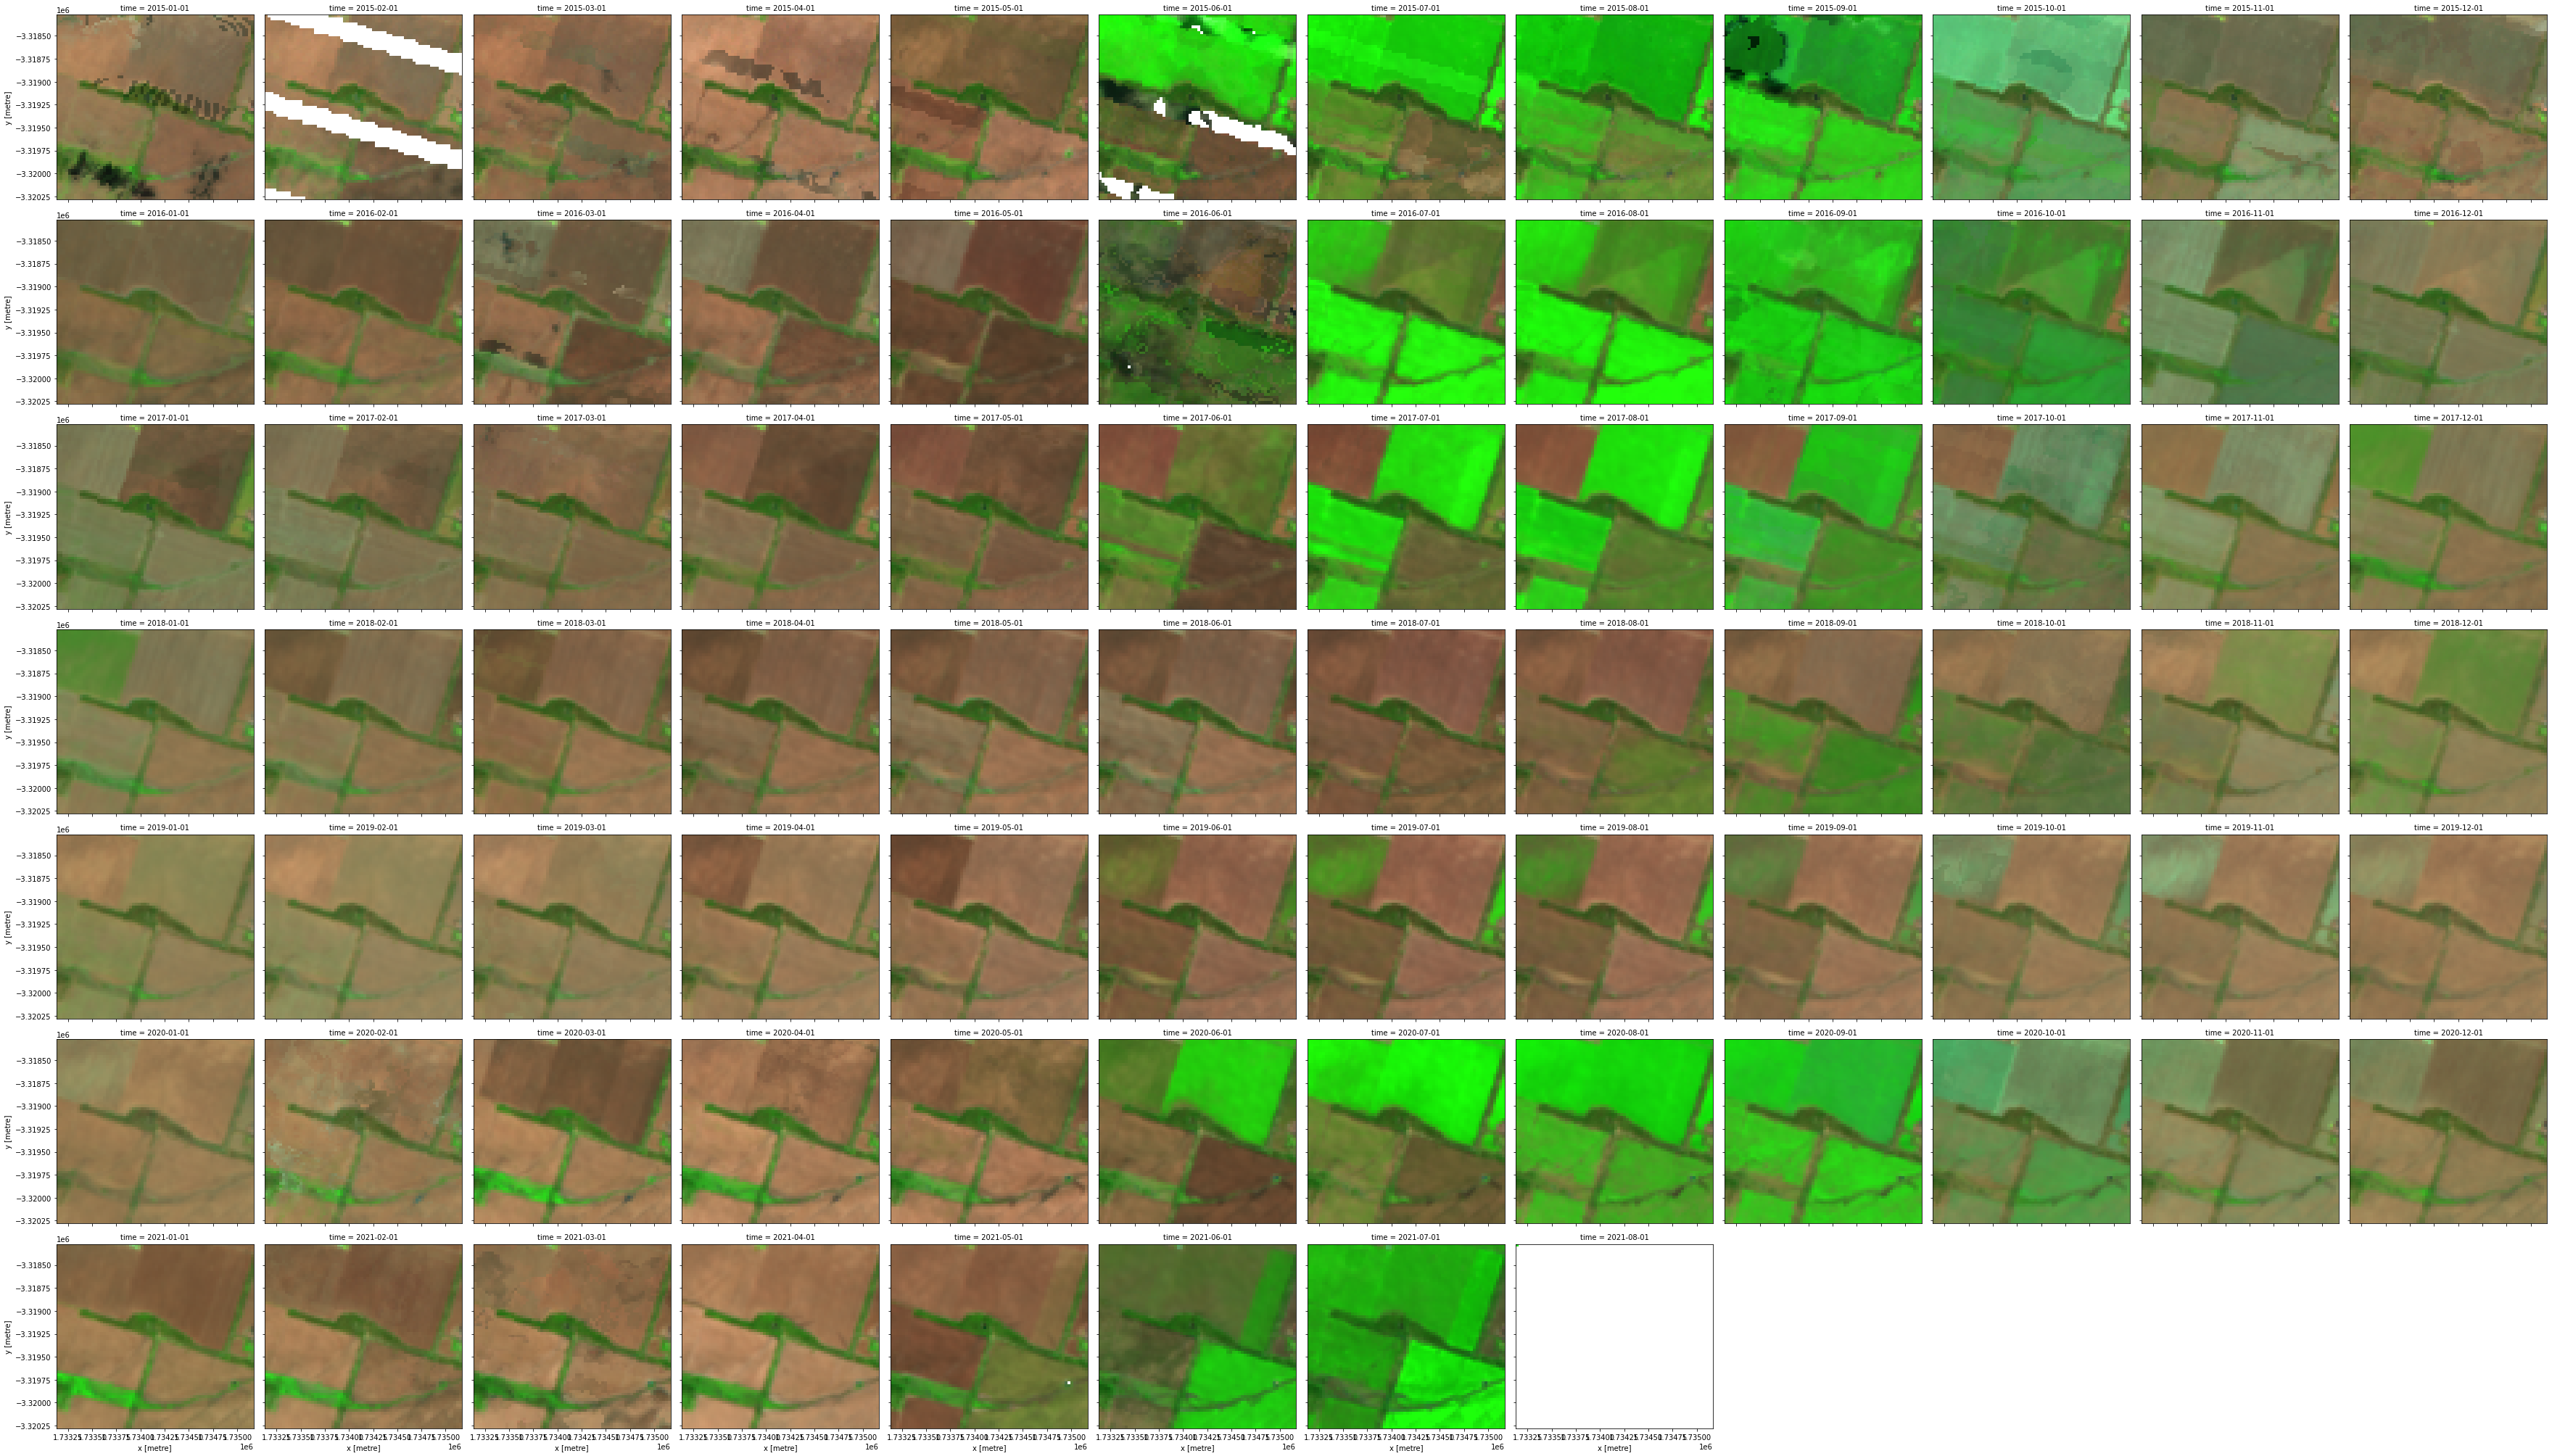

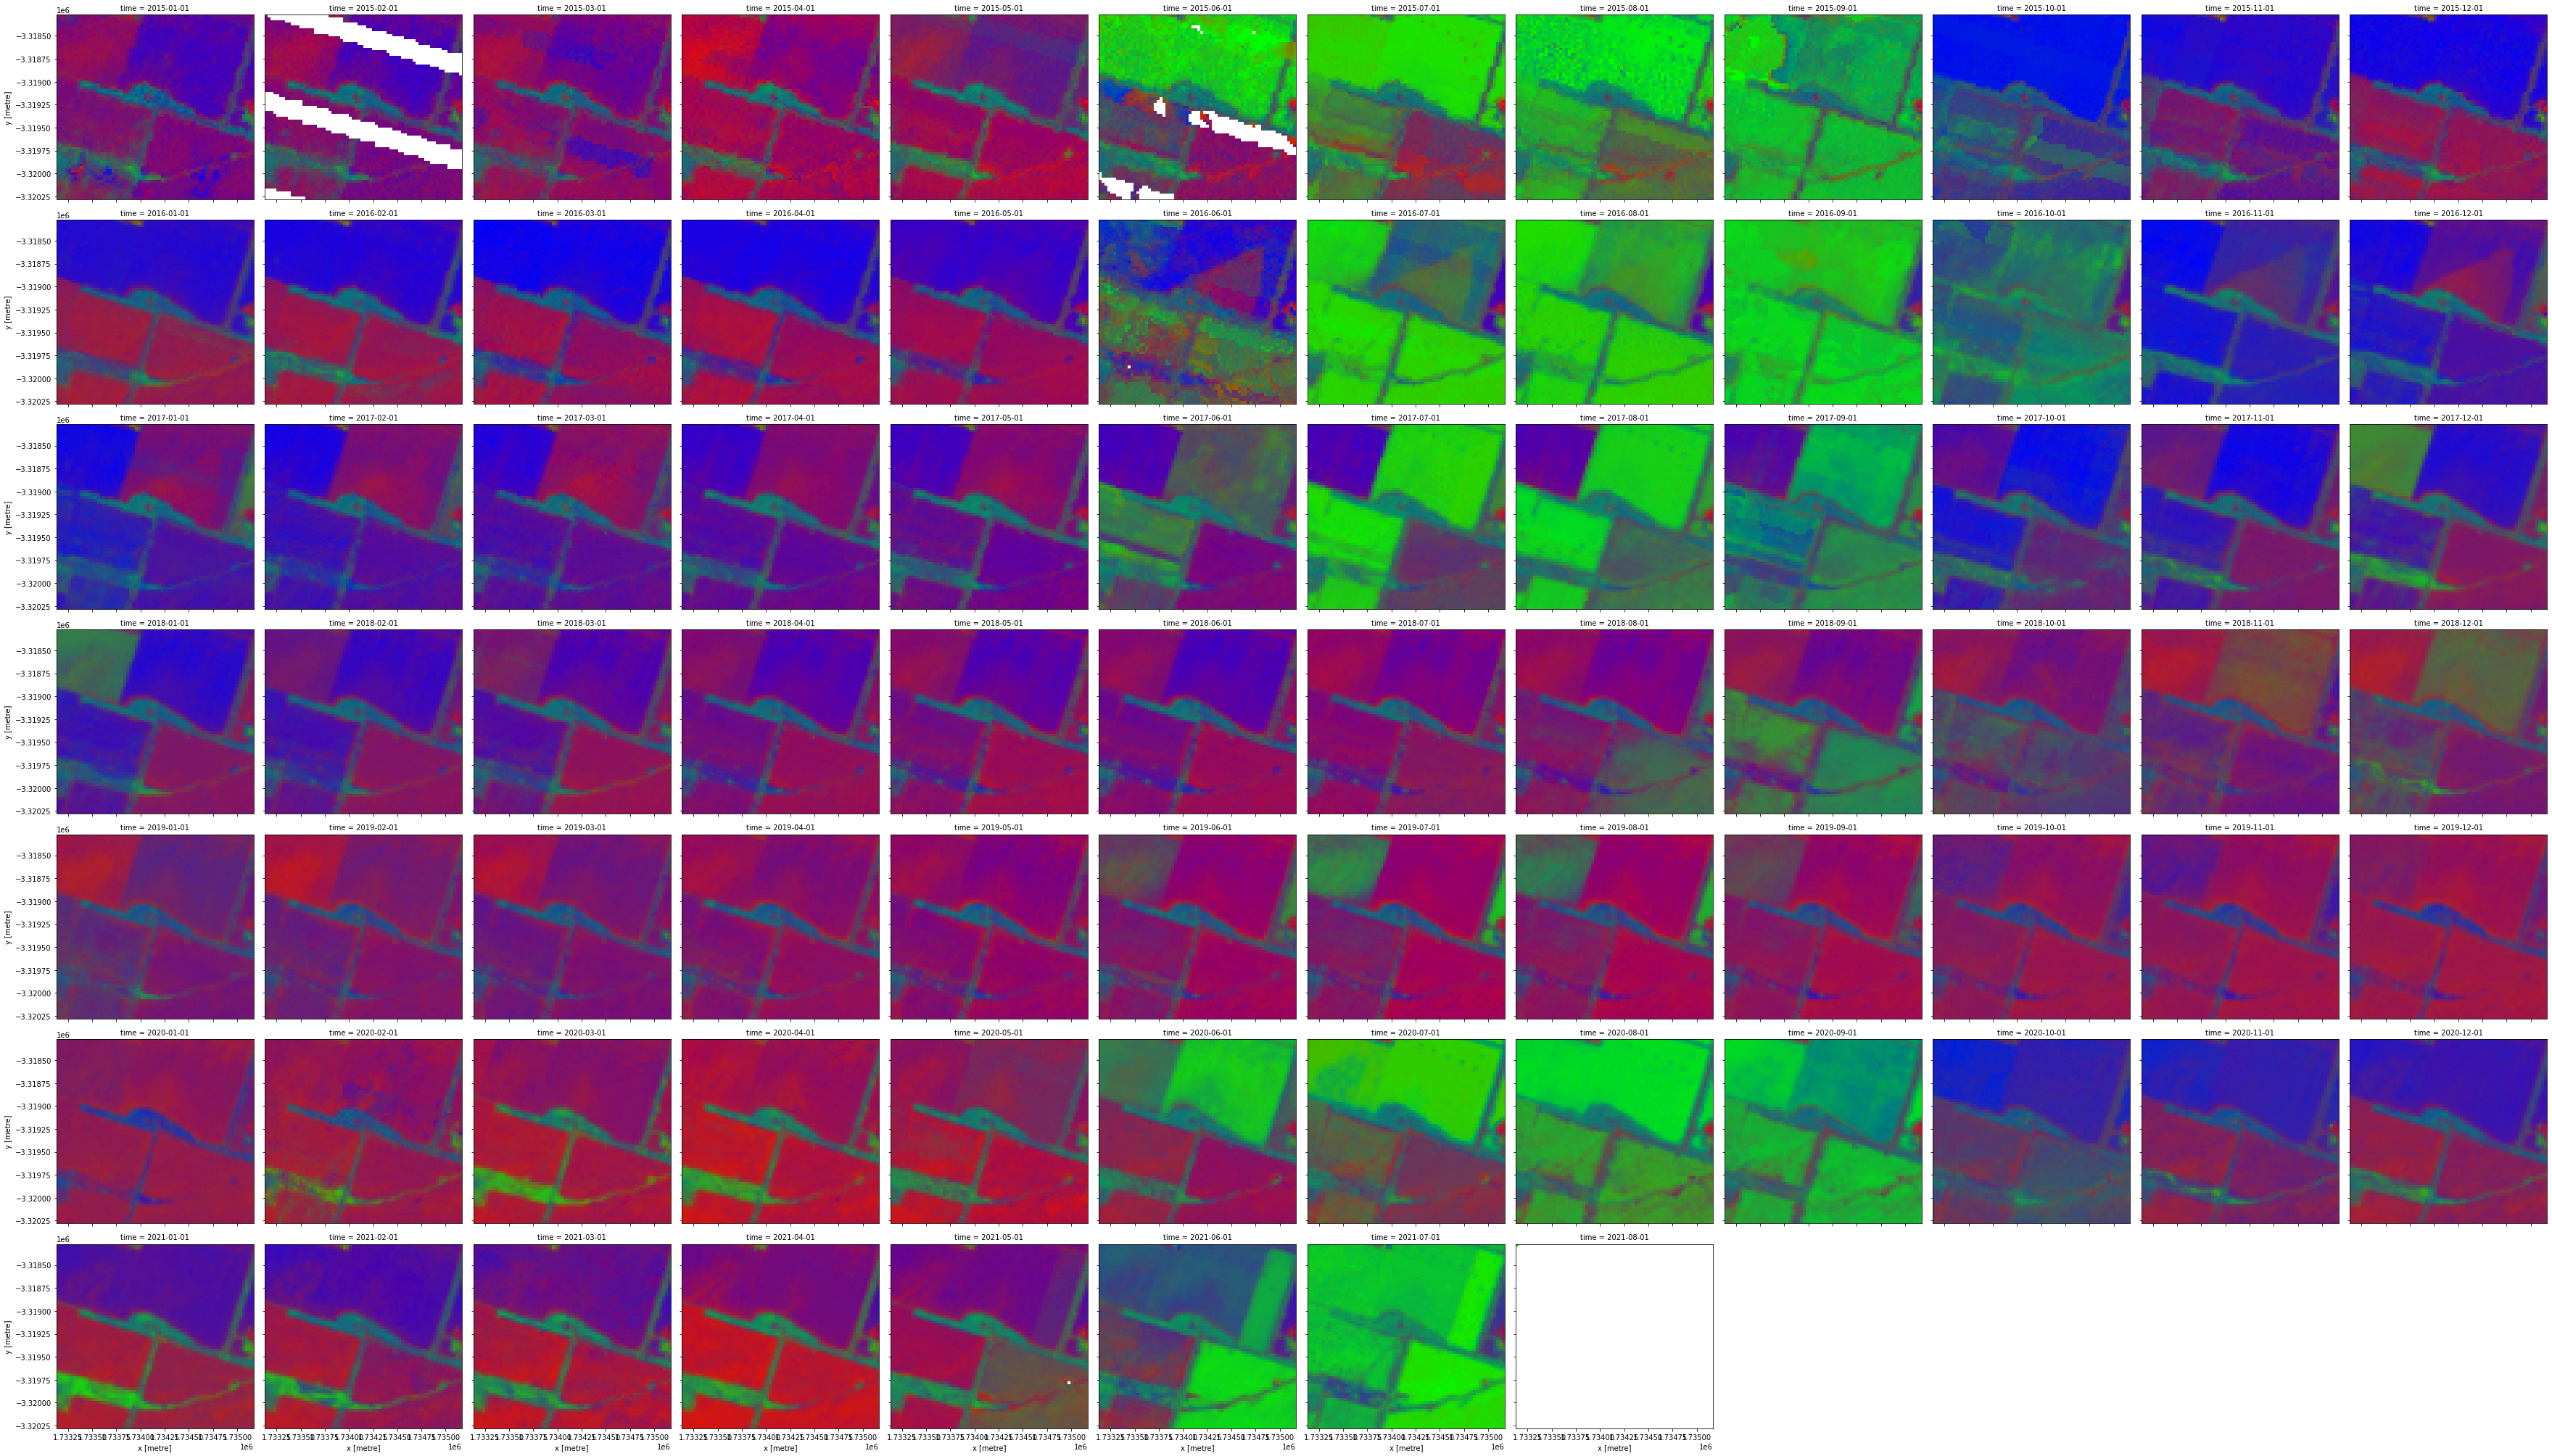

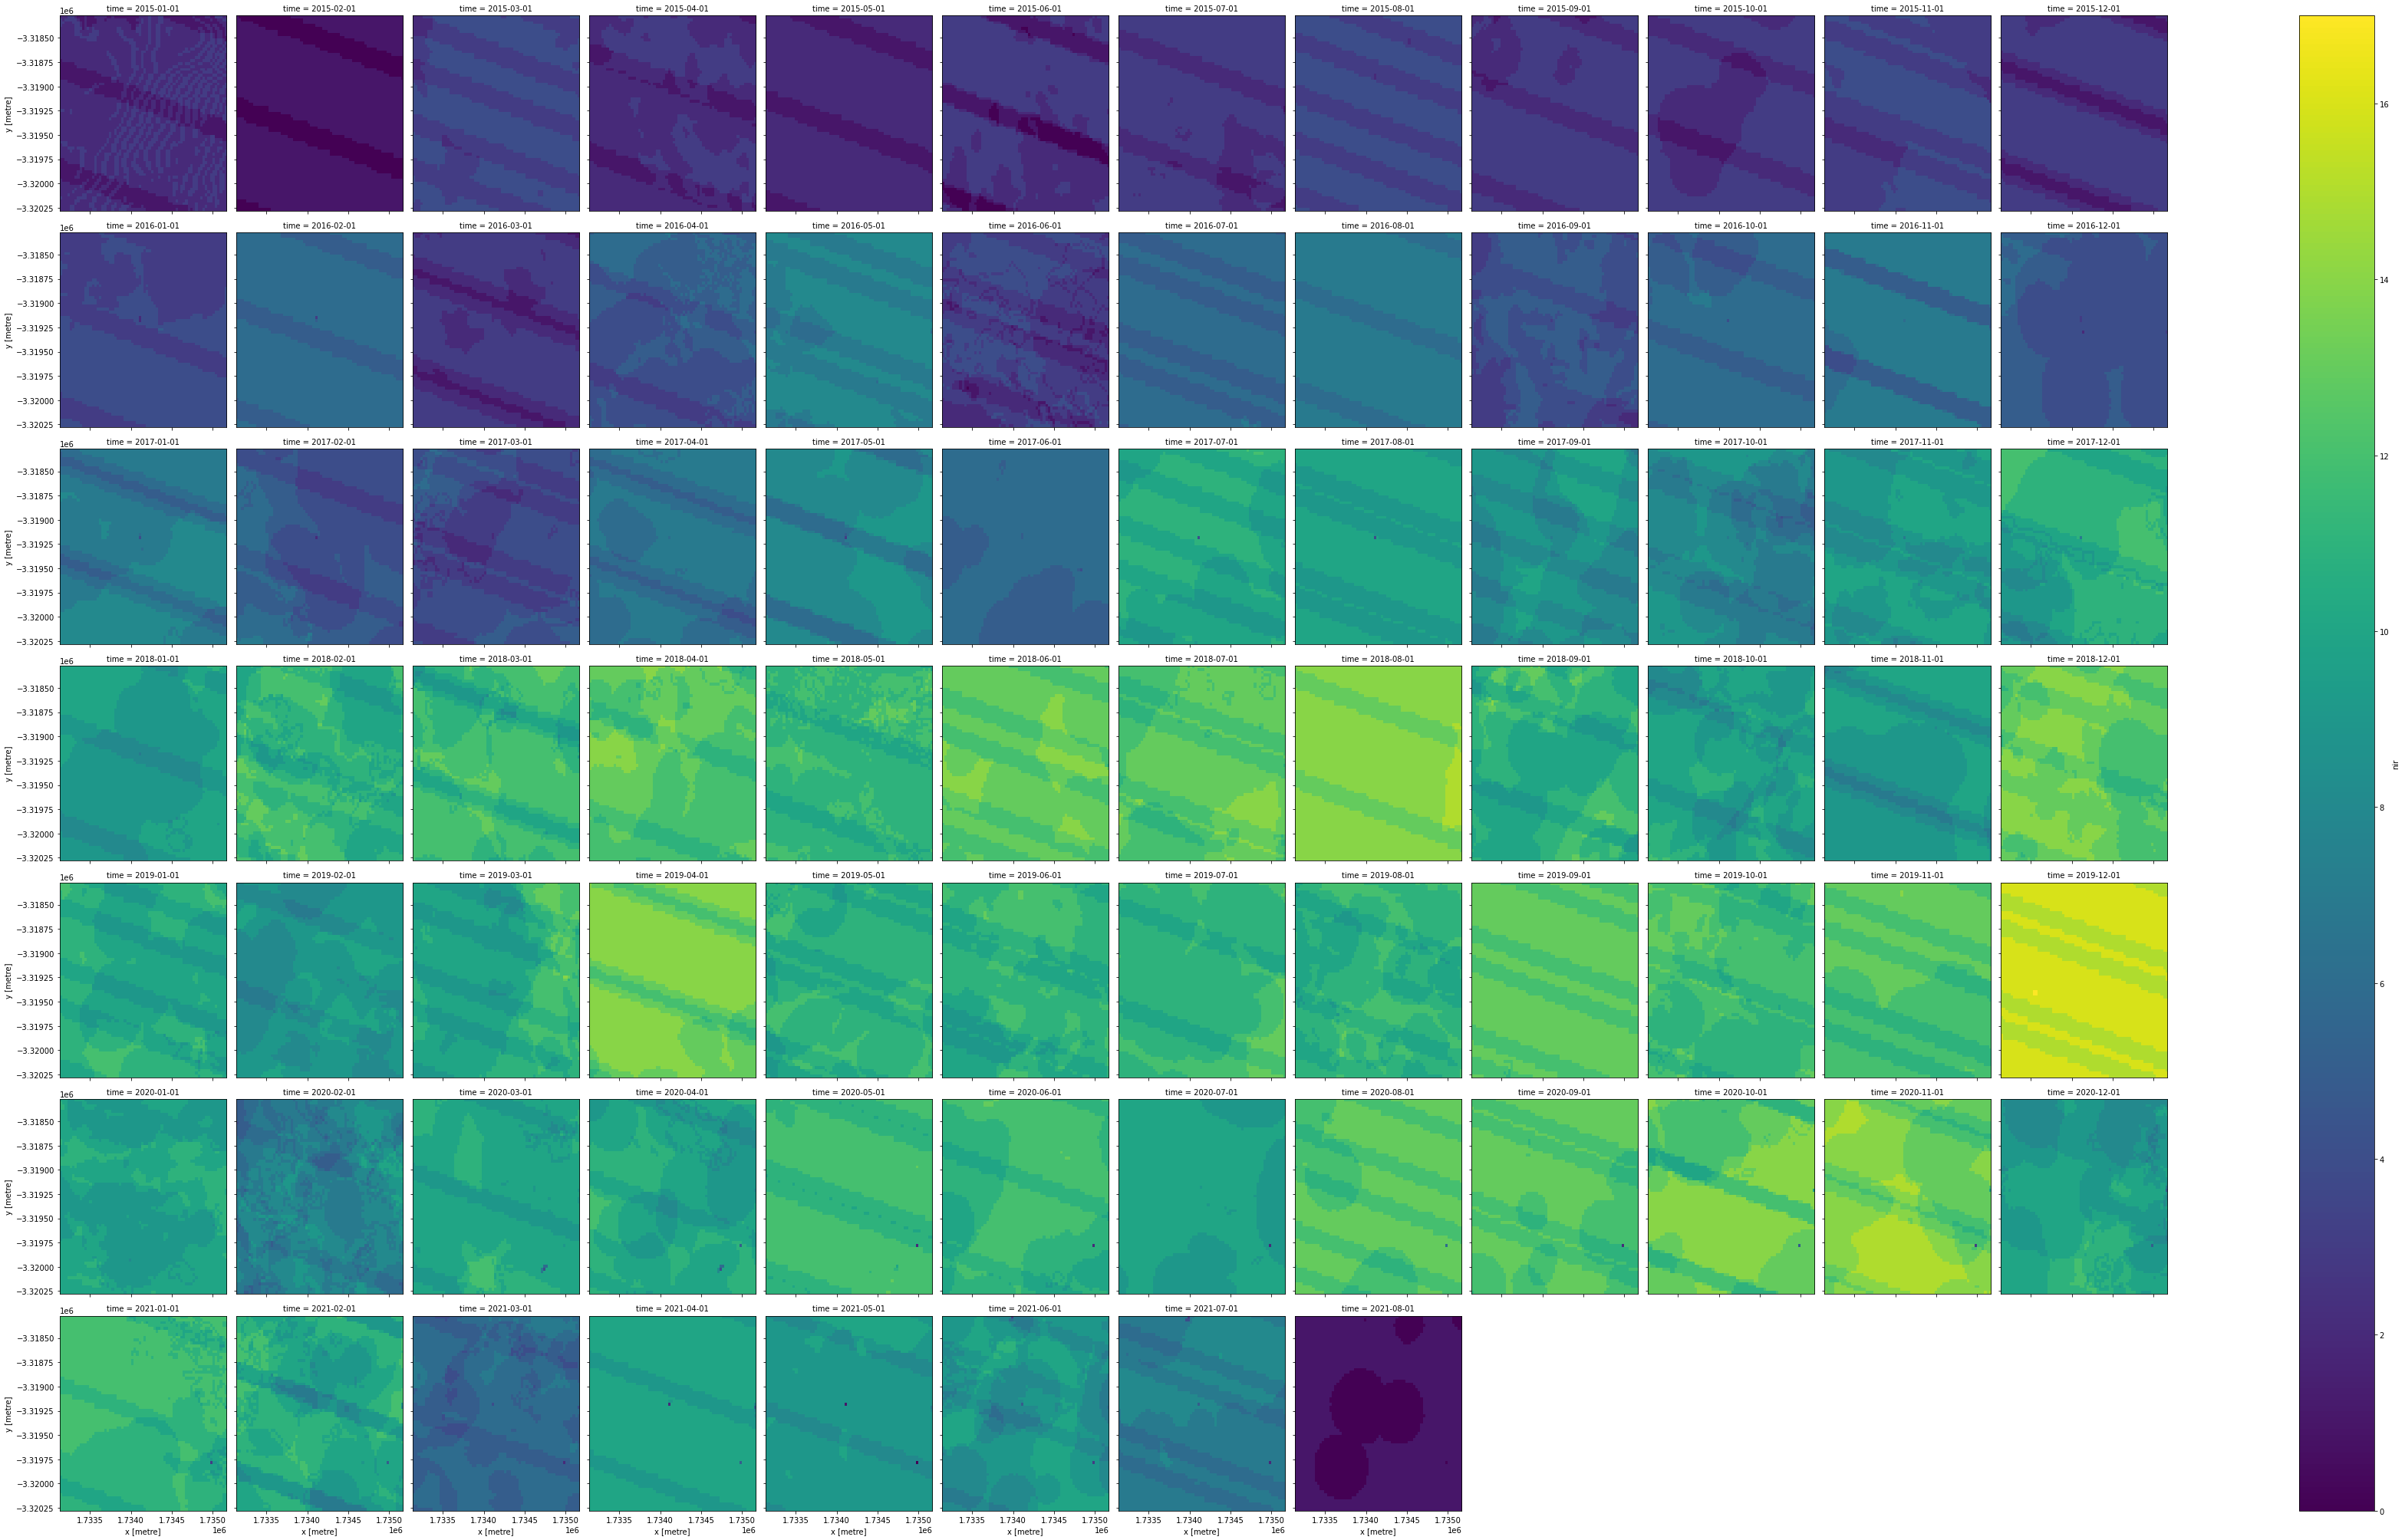

In [71]:
size=4
#L_S2[['swir2', 'nir', 'red']].to_array().plot.imshow(col='time', col_wrap=6, vmin=0, vmax=5000, size=size)
L_S2_gm[['swir2', 'nir', 'red']].to_array().plot.imshow(col='time', col_wrap=12, vmin=0, vmax=5000, size=size)


fc_unmix[['bs', 'pv', 'npv']].to_array().plot.imshow(col='time', col_wrap=12, vmin=0, vmax=100, size=size)
 
L_S2_gm_n['nir'].plot.imshow(col='time', col_wrap=12, size=size)
#plt.savefig('../fc_juan/'+date_init+'_L578_false_color.png')
plt.show()


 

## save the results (TBC)